# Projeto de IA

In [26]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from random import uniform
import math
import random as rd

MAX_ITER = 15

In [27]:
iris = datasets.load_iris()



In [28]:
def plotter(doc, ks, label):
    X,Y = zip(*doc)
    kx,ky = zip(*ks)

    plt.scatter(x=X,y=Y, marker='o', c=label)
    plt.scatter(x=kx, y=ky, marker='x', color='black', s=150)


In [29]:
def euclidianDistance(p1, p2):
    return math.sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )

In [30]:
def goCondition(old_centroids, curr_centroids, itter):
    if itter >= MAX_ITER: return False    
    
    ctd = 0
    for old_centroid,curr_centroid in zip(old_centroids,curr_centroids):
        if abs(old_centroid[0]-curr_centroid[0]) <= 0.001 and\
           abs(old_centroid[1]-curr_centroid[1]) <= 0.001:
               ctd += 1
    if ctd == len(curr_centroids): return False
    
    return True
    

In [37]:
def calculateAllDistances(positions, centroids, distFunction=euclidianDistance):
    distances = list()
    for pos in positions:
        list_per_cent = list()
        for index, cent in enumerate(centroids):
            list_per_cent.append(distFunction(cent, pos))

        distances.append(list_per_cent)

    return distances

In [38]:
def giveOwnership(distances):
    label = list()
    for dist in distances:
        min_dist = min(dist)
        label.append(dist.index(min_dist))

    return label


In [44]:
def generateCentroids(list_x, list_y, k):
    (min_x, min_y) = (min(list_x)-(min(list_x)*0.2),\
                      min(list_y)-(min(list_y)*0.2))
    (max_x, max_y) = (max(list_x)+(max(list_x)*0.2),\
                      max(list_y)+(max(list_y)*0.2))

    return [(uniform(min_x, max_x), uniform(min_y, max_y)) for i in range(k)]

In [45]:
def updateCentroids(positions, labels, k):
    new_centroids = list()
    for i in range(k):
        qtd = len([x for x in labels if x == i])
        point = [0, 0]
        for j, pos in enumerate(positions):
            if labels[j] == i:
                point[0] += pos[0]
                point[1] += pos[1]

        point[0] /= qtd + 0.000000000001
        point[1] /= qtd + 0.000000000001
        new_centroids.append((point[0], point[1]))

    return new_centroids


In [46]:
def kmeans(list_x, list_y, k=1, iter_times=100000, distFunction=euclidianDistance):
    positions = list(zip(list_x, list_y))
    centroids = generateCentroids(list_x, list_y, k)
    distances = calculateAllDistances(positions, centroids, distFunction)
    labels = giveOwnership(distances)

    iter = 0
    has_changed = True

    while has_changed and iter <= iter_times:
        centroids = updateCentroids(positions, labels, k)
        distances = calculateAllDistances(positions, centroids, distFunction)
        labels = giveOwnership(distances)

        iter += 1

    return labels, centroids


[1, 1, 1, 0, 0, 1, 0, 1, 1]


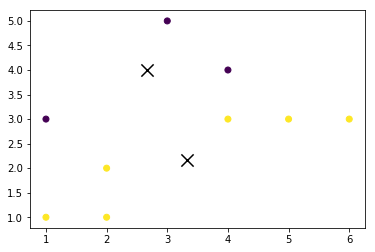

In [80]:
vecx = [1, 2, 2, 1, 3, 4, 4, 5, 6]
vecy = [1, 1, 2, 3, 5, 3, 4, 3, 3]

K = 2

label, centroids = kmeans(vecx, vecy, k=K, distFunction=euclidianDistance)
print(label)
plotter(zip(vecx, vecy), centroids, label)
